In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class GradientDescent(tf.Module):
    def __init__(self, learning_rate=1e-3):
        self.learning_rate = learning_rate
        self.title = f"Gradient descent optimizer: learning rate={self.learning_rate}"

    def apply_gradients(self, grads, vars):
        for g, v in zip(grads, vars):
            v.assign_sub(self.learning_rate * g)


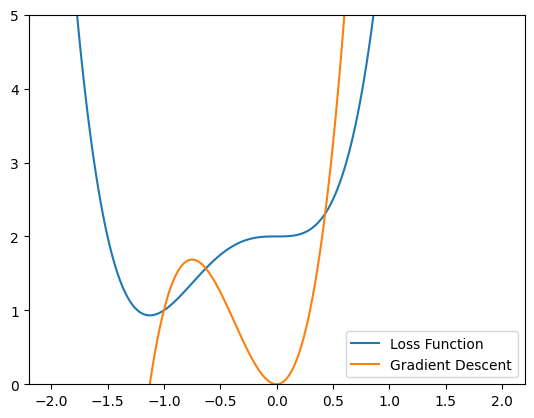

In [3]:
x_vals = tf.linspace(-2, 2, 201)
x_vals = tf.cast(x_vals, tf.float32)


def loss(x):
    return 2 * (x**4) + 3 * (x**3) + 2


def grad(f, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        result = f(x)

    return tape.gradient(result, x)


plt.plot(x_vals, loss(x_vals), label='Loss Function')
plt.plot(x_vals, grad(loss, x_vals), label='Gradient Descent')
plt.ylim(0, 5)
plt.legend()


In [4]:
def convergence_test(optimizer, loss_fn, grad_fn, init_value=2., epochs=2000):
    param_path = []

    x_current = tf.Variable(init_value, name='x_current')
    has_converged = False

    for epoch in range(1, epochs + 1):
        x_grad = grad_fn(loss_fn, x_current)

        if tf.math.is_nan(x_grad):
            print(f'Gradient exploded after {epoch} for learning rate {optimizer.learning_rate}')
            return []

        x_old = x_current.numpy()
        optimizer.apply_gradients([x_grad], [x_current])

        param_path.append(x_current.numpy())
        if x_old == x_current.numpy():
            print(f'Converged after {epoch} epochs, with learning rate {optimizer.learning_rate}')
            has_converged = True
            break

    if not has_converged:
        print(f'Could not converge after {epoch} epochs for learning rate {optimizer.learning_rate}')

    return param_path


Gradient exploded after 6 for learning rate 0.1
Could not converge after 2000 epochs for learning rate 0.01
Could not converge after 2000 epochs for learning rate 0.001


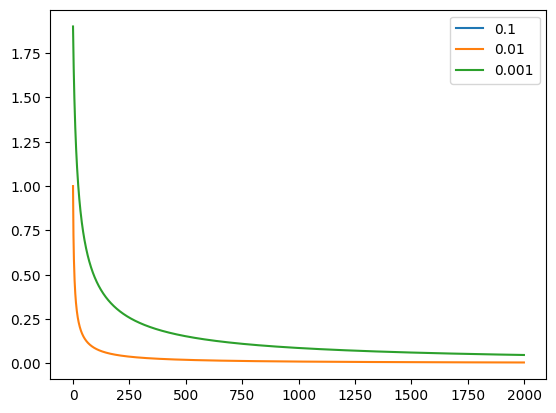

In [5]:
param_path_1 = convergence_test(optimizer=GradientDescent(learning_rate=0.1),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_01 = convergence_test(optimizer=GradientDescent(learning_rate=0.01),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_001 = convergence_test(optimizer=GradientDescent(learning_rate=0.001),
                 grad_fn=grad, loss_fn=loss, init_value=2.)

plt.plot(range(len(param_path_1)), param_path_1, label='0.1')
plt.plot(range(len(param_path_01)), param_path_01, label='0.01')
plt.plot(range(len(param_path_001)), param_path_001, label='0.001')
plt.legend()

In [6]:
class Momentum(tf.Module):
    def __init__(self, learning_rate=1e-3, momentum=0.7):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.change = 0

    def apply_gradients(self, grads, vars):
        for g, v in zip(grads, vars):
            curr_change = self.learning_rate * g + self.momentum * self.change
            v.assign_sub(curr_change)
            self.change = curr_change

Gradient exploded after 6 for learning rate 0.1
Converged after 80 epochs, with learning rate 0.01
Could not converge after 2000 epochs for learning rate 0.001


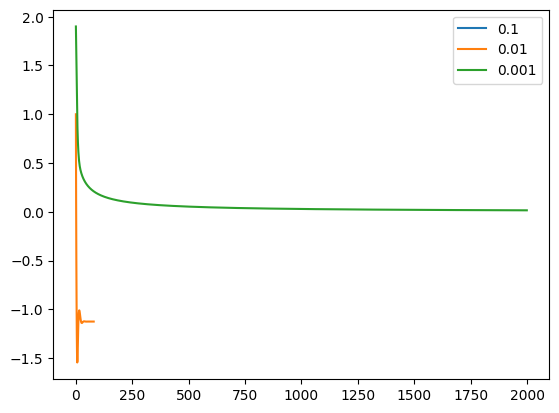

In [7]:
param_path_1 = convergence_test(optimizer=Momentum(learning_rate=0.1),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_01 = convergence_test(optimizer=Momentum(learning_rate=0.01),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_001 = convergence_test(optimizer=Momentum(learning_rate=0.001),
                 grad_fn=grad, loss_fn=loss, init_value=2.)

plt.plot(range(len(param_path_1)), param_path_1, label='0.1')
plt.plot(range(len(param_path_01)), param_path_01, label='0.01')
plt.plot(range(len(param_path_001)), param_path_001, label='0.001')
plt.legend()

In [8]:
class Adam(tf.Module):
    def __init__(self, learning_rate=1e-3, beta_1=0.9, beta_2=0.999, ep=1e-7):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.ep = ep
        self.v_dvar = []
        self.s_dvar = []
        self.t = 1.

        self.built = False

    def apply_gradients(self, grads, variables):
        if not self.built:
            for v in variables:
                self.v_dvar.append(tf.Variable(tf.zeros(shape=v.shape), dtype=tf.float32))
                self.s_dvar.append(tf.Variable(tf.zeros(shape=v.shape), dtype=tf.float32))

            self.built = True

        for i, (g, v) in enumerate(zip(grads, variables)):
            self.v_dvar[i] = tf.add(tf.multiply(self.beta_1, self.v_dvar[i]), tf.multiply(tf.subtract(1., self.beta_1), g))
            self.s_dvar[i] = tf.add(tf.multiply(self.beta_2, self.s_dvar[i]), tf.multiply(tf.subtract(1., self.beta_2), tf.square(g)))

            v_dvar_bc = tf.divide(self.v_dvar[i], tf.subtract(1., tf.pow(self.beta_1, self.t)))
            s_dvar_bc = tf.divide(self.s_dvar[i], tf.subtract(1., tf.pow(self.beta_2, self.t)))

            v.assign_sub(tf.multiply(self.learning_rate, tf.divide(v_dvar_bc, tf.add(tf.sqrt(s_dvar_bc), self.ep))))

        self.t += 1

Converged after 1156 epochs, with learning rate 0.1
Could not converge after 2000 epochs for learning rate 0.01
Could not converge after 2000 epochs for learning rate 0.001


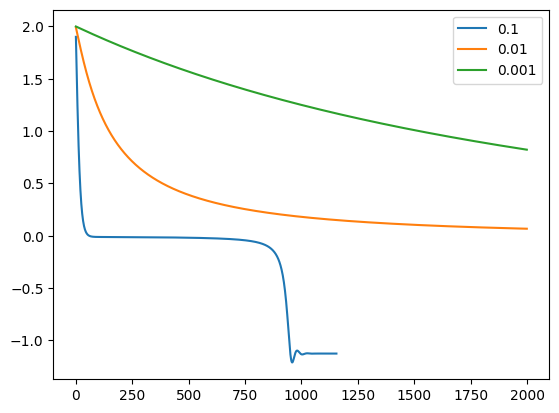

In [9]:
param_path_1 = convergence_test(optimizer=Adam(learning_rate=0.1),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_01 = convergence_test(optimizer=Adam(learning_rate=0.01),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_001 = convergence_test(optimizer=Adam(learning_rate=0.001),
                 grad_fn=grad, loss_fn=loss, init_value=2.)

plt.plot(range(len(param_path_1)), param_path_1, label='0.1')
plt.plot(range(len(param_path_01)), param_path_01, label='0.01')
plt.plot(range(len(param_path_001)), param_path_001, label='0.001')
plt.legend()

In [10]:
class Momentum2(tf.Module):
    def __init__(self, learning_rate=1e-3, momentum=0.9):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.t = 1.
        self.v_dvar = []

        self.built = False

    def apply_gradients(self, grads, variables):
        if not self.built:
            for v in variables:
                self.v_dvar.append(tf.zeros(shape=v.shape, dtype=tf.float32))

            self.built = True

        for i, (g, v) in enumerate(zip(grads, variables)):
            self.v_dvar[i] = tf.add(tf.multiply(
                self.momentum, self.v_dvar[i]), tf.multiply(tf.subtract(1., self.momentum), g))

            v_dvar_bc = tf.divide(self.v_dvar[i], tf.subtract(
                1., tf.pow(self.momentum, self.t)))

            v.assign_sub(tf.multiply(self.learning_rate, v_dvar_bc))
            
        self.t += 1


Gradient exploded after 6 for learning rate 0.1
Converged after 230 epochs, with learning rate 0.01
Could not converge after 2000 epochs for learning rate 0.001


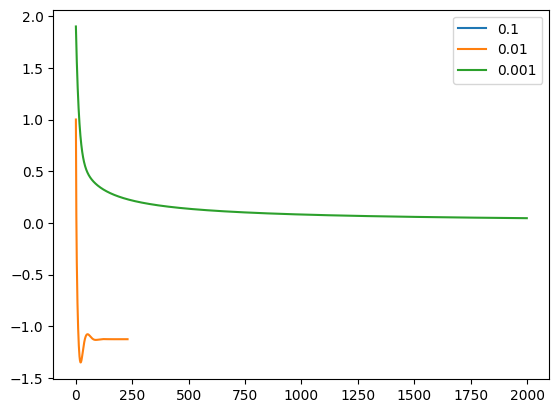

In [11]:
param_path_1 = convergence_test(optimizer=Momentum2(learning_rate=0.1),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_01 = convergence_test(optimizer=Momentum2(learning_rate=0.01),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_001 = convergence_test(optimizer=Momentum2(learning_rate=0.001),
                 grad_fn=grad, loss_fn=loss, init_value=2.)

plt.plot(range(len(param_path_1)), param_path_1, label='0.1')
plt.plot(range(len(param_path_01)), param_path_01, label='0.01')
plt.plot(range(len(param_path_001)), param_path_001, label='0.001')
plt.legend()

In [12]:
class RMSProp(tf.Module):
    def __init__(self, learning_rate=1e-3, momentum=0.999, ep=1e-7):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.ep = ep
        self.t = 1.

        self.s_dvar = []

        self.built = False

    def apply_gradients(self, grads, variables):
        if not self.built:
            for v in variables:
                self.s_dvar.append(tf.zeros(shape=v.shape, dtype=tf.float32))

            self.built = True

        for i, (g, v) in enumerate(zip(grads, variables)):
            self.s_dvar[i] = tf.add(tf.multiply(self.momentum, self.s_dvar[i]), tf.multiply(
                tf.subtract(1., self.momentum), tf.square(g)))

            s_dvar_bc = tf.divide(self.s_dvar[i], tf.subtract(
                1., tf.pow(self.momentum, self.t)))

            v.assign_sub(tf.multiply(self.learning_rate, tf.divide(
                g, tf.add(tf.sqrt(self.s_dvar[i]), self.ep))))

        self.t += 1


Converged after 34 epochs, with learning rate 0.1
Could not converge after 2000 epochs for learning rate 0.01
Could not converge after 2000 epochs for learning rate 0.001


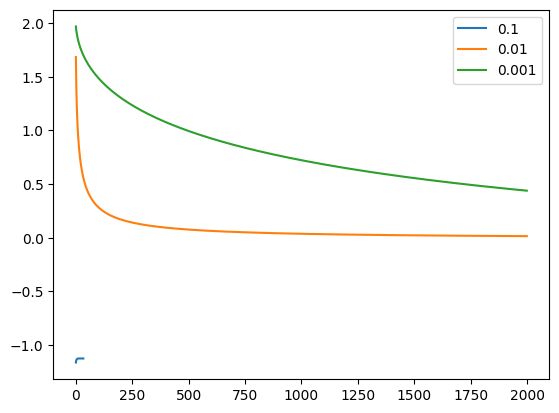

In [13]:
param_path_1 = convergence_test(optimizer=RMSProp(learning_rate=0.1),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_01 = convergence_test(optimizer=RMSProp(learning_rate=0.01),
                 grad_fn=grad, loss_fn=loss, init_value=2.)
param_path_001 = convergence_test(optimizer=RMSProp(learning_rate=0.001),
                 grad_fn=grad, loss_fn=loss, init_value=2.)

plt.plot(range(len(param_path_1)), param_path_1, label='0.1')
plt.plot(range(len(param_path_01)), param_path_01, label='0.01')
plt.plot(range(len(param_path_001)), param_path_001, label='0.001')
plt.legend()